# HW 4: Hierarchical Regression and Bayesian Model Averaging

Matt Scheffel (mcs9ff)

7/28/23

On my honor, I have neither given nor received any aid on this assignment.

# Part 1: Bayesian Hierarchical Modelling (60 points)

You have been hired by a regional chain of coffee shops to help improve sales and to examine how the personality characteristics of individual store managers might impact the sales numbers of both coffee and food. The client as the following questions they need answered:

• How does conscientiousness and neuroticism impact the sales of coffee and food, and are coffee and food impacted differently?

• Once you control for the personality characteristics of the store managers, what stores should be performing well? (i.e. the rest of the employees might be great, but the store manager might be bringing sales down)

1. Problem Statement - What problem are you tackling?

2. Approach - Describe the model you are using. Present it both in equation form, as well as a written description of the model. Importantly, you are not writing this for another data scientist, you are writing this for someone who is capable of understanding what a regression is, and what these sorts of models can provide, but has never worked with data analyses or statistics before (so smart, but without the same knowledge base you have.)

3. Prior Rationale - List your prior choices and why those were chosen.

4. Findings - This is where you present your findings.

5. Summary - This is where you summarize and interpret what your analyses uncovered. Again, this is for the client, so it needs to be usable information for them.

6. Diagnostics - This is where you put information/plots as to how the estimator performed. This is for technical reference (I like to always have these in the reports I create, but this information is not really for a client per say, more for another data scientist to validate your work.) This doesn’t need to be long.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pymc3 import get_data

# import as pm to work in Jupyter notebook

import pymc3 as pm

sns.set_context('notebook')
sns.set_style('white')

In [2]:
coffee_sales = pd.read_csv("sales-ds6040sum2021.csv")
coffee_sales

,sales,food,con,neur,store
0,1.363821,0,0.216553,1.290224,0
1,-1.119747,1,0.216553,1.290224,0
2,-0.180141,0,0.216553,1.290224,0
3,-2.282334,1,0.216553,1.290224,0
4,0.673304,0,0.216553,1.290224,0
...,...,...,...,...,...
475,0.063563,1,0.306285,-0.070093,19
476,0.206535,0,0.306285,-0.070093,19
477,-1.540875,1,0.306285,-0.070093,19
478,-0.361400,0,0.306285,-0.070093,19


# 1.1 - Problem Statement

The problem we are being asked to tackle is to determine for a client (the regional chain of coffee shops) to help improve sales by examinign the personality characteristics of individual store managers. Specifically, we are to determine how conscientiousness and neuroticism impact the sales of coffee and food, and whether coffee and food impacted differently. 

# 1.2 - Approach

As seen from the column headers above, the dataset contains variables related to sales, food/coffee, conscientiousness, neuroticism, and the store identifier. We will need to determine the number of stores and how each specific stores' sales are impacted by the personality of the different store managers.

In [3]:
print(len(coffee_sales.store.unique()))

20


We will be differentiating between 20 different stores, with each individual store appearing to have a consistent conscientiousness and neuroticism level associated witht the store ID number.

Store 14 appears to stand out as a significant leader in sales performance:

In [4]:
top_10 = coffee_sales.sort_values(by = 'sales', ascending = False).head(10)
top_10

,sales,food,con,neur,store
349,6.691813,1,0.587351,-0.646036,14
351,5.860888,1,0.587351,-0.646036,14
337,5.413579,1,0.587351,-0.646036,14
353,5.392009,1,0.587351,-0.646036,14
348,5.115312,0,0.587351,-0.646036,14
350,4.934820,0,0.587351,-0.646036,14
345,4.756127,1,0.587351,-0.646036,14
352,4.585693,0,0.587351,-0.646036,14
354,4.516702,0,0.587351,-0.646036,14
343,4.500990,1,0.587351,-0.646036,14


In [5]:
bottom_10 = coffee_sales.sort_values(by = 'sales').head(10)
bottom_10

,sales,food,con,neur,store
405,-5.651358,1,-0.501073,-0.953021,16
217,-5.384762,1,-0.568532,0.966242,9
301,-4.389198,1,-0.717169,-0.036987,12
183,-4.194727,1,-2.018870,-1.069713,7
227,-3.852984,1,-0.568532,0.966242,9
177,-3.713534,1,-2.018870,-1.069713,7
395,-3.579424,1,-0.501073,-0.953021,16
236,-3.398807,0,-0.568532,0.966242,9
235,-3.365326,1,-0.568532,0.966242,9
239,-3.361530,1,-0.568532,0.966242,9


We also can find what appears to be a positive correlation between conscientiousness and store sales, while store sales and neuroticism appear to have a negative correlation:

<AxesSubplot:>

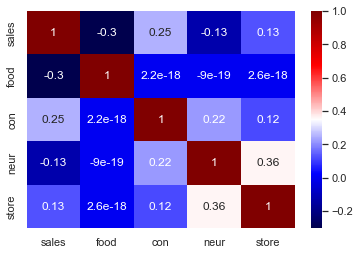

In [6]:
sns.heatmap(coffee_sales.corr(), annot = True, cmap = "seismic")

For this study, we will be using the hieraarchical modeling approach. In this case, the "hierarchy" is the stores.

Our equation will be:

$\hat{\text{sales}} = \alpha_{store} + {\alpha\text{_} f}_{store} + \beta * \text{con} + \beta_f * \text{con} + \gamma * \text{neur} + \gamma_f * \text{neur}$

with:

$\beta$ as the effect of conscientiousness for coffee, representing how much the sales are expected to change with a one-unit increase in conscientiousness (con) for coffee products while keeping other variables constant.

$\beta_f$ as the difference in the effect of conscientiousness between coffee and food, indicating how much the effect of conscientiousness on sales differs between coffee and food products.

$\gamma$ as the effect of neuroticism for coffee. Similar to $\beta$, it represents how much the sales are expected to change with a one-unit increase in neuroticism (neur) for coffee products while keeping other variables constant.

$\gamma_f$ as the difference in the effect of neuroticism between coffee and food, showing how much the effect of neuroticism on sales differs between coffee and food products.

$\alpha$ as the hierarchical effect as well as overall intercept, representing the level of sales at the mean levels of conscientiousness and neuroticism for both coffee and food. Essentially, it gives the baseline sales level when both conscientiousness and neuroticism are at their average values for both coffee and food products.

# Code:

In [7]:
# needed to set these as values to avoid indexing errors

store = coffee_sales.store.values
store_numbers = len(coffee_sales.store.unique())
food = coffee_sales.food.values
con = coffee_sales.con.values
neur = coffee_sales.neur.values

In [8]:
with pm.Model() as hierarchical_model:
    # Priors for the fixed effects
    # a - overall intercept, level of sales at mean levels of conscientiousness and neuroticism
    mu_a = pm.Normal('mu_a', mu=0., sd=1e5)
    sigma_a = pm.HalfCauchy('sigma_a', 5)
    # food
    mu_a_f = pm.Normal('mu_a_f', mu=0., sd=1e5)
    sigma_a_f = pm.HalfCauchy('sigma_a_f', 5)
    
    # sales intercepts as offsets
    a_offset = pm.Normal('a_offset', mu=0, sd=1, shape = 20)
    a = pm.Deterministic("a", mu_a + a_offset * sigma_a)
    # food
    a_offset_f = pm.Normal('a_offset_f', mu = 0, sd = 1, shape = 20)
    a_f = pm.Deterministic("a_f", mu_a_f + a_offset_f * sigma_a_f)
    
    # store level effect of conscientiousness as offset
    b_offset = pm.Normal('b_offset', mu=0, sd=1)
    b = pm.Deterministic("b", b_offset)
    # food
    b_offset_f = pm.Normal('b_offset_f', mu=0, sd=1)
    b_f = pm.Deterministic("b_f", b_offset_f)
    
    # store level effect of neuroticism as offset
    c_offset = pm.Normal('c_offset', mu=0, sd=1)
    c = pm.Deterministic("c", c_offset)
    # food
    c_offset_f = pm.Normal('c_offset_f', mu=0, sd=1)
    c_f = pm.Deterministic("c_f", c_offset_f)
    
    # Residual Error
    res_error = pm.HalfCauchy('res_error', 5)
    
    # This is the specification for the regression equation itself.
    sales_reg = a[store] + a_f[store]*food + b *con + b_f*con*food + c *neur + c_f*neur*food

    # Data likelihood
    sales_likelihood = pm.Normal('sales_likelihood', mu = sales_reg, sd = res_error, observed = coffee_sales.sales)

In [9]:
with hierarchical_model:
    hierarchical_trace = pm.sample(1000, n_init = 50000, tune = 1000)

/Users/matthewscheffel/opt/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [res_error, c_offset_f, c_offset, b_offset_f, b_offset, a_offset_f, a_offset, sigma_a_f, mu_a_f, sigma_a, mu_a]


/Users/matthewscheffel/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/matthewscheffel/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/matthewscheffel/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/matthewscheffel/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.


# 1.3 - Prior Rationale

The prior distributions for the coefficients $\alpha$ and $\alpha_f$ were chosen as follows:

$\mu$ is set to follow a normal distribution with mean 0 and a large standard deviation of 10000.
$\sigma$ is set to follow a Half-Cauchy distribution with scale parameter 5.
An offset is drawn from a normal distribution with mean 0 and standard deviation 1. The shape is 20.
The coefficient $\alpha$ is then determined as the sum of $\mu$ and each element of the offset vector multiplied by $\sigma$.
The motivation behind using such wide priors for $\alpha$ and $\alpha_f$ is due to the lack of clear information or strong prior beliefs about their values. By employing these large priors, the model can maintain flexibility and allow for a more general representation of the posterior distributions.

For the coefficients $\beta$, $\beta_f$, $\gamma$, and $\gamma_f$, the prior information is as follows:

An offset is drawn from a normal distribution with mean 0 and standard deviation 1.
The coefficient of interest (e.g., $\beta$, $\beta_f$, $\gamma$, or $\gamma_f$) is determined as the value of the offset.
These priors are chosen similarly to the $\alpha$ and $\alpha_f$ priors because there is limited prior information about the data. Moreover, since $\beta$, $\beta_f$, $\gamma$, and $\gamma_f$ have the same structure within each store (conscientiousness and neuroticism are the same within each store), there is no need for a shape input.

Overall, these prior choices aim to account for uncertainty and avoid imposing strong assumptions on the coefficient values, allowing the model to be more flexible in representing the data's behavior.

# 1.4 - Findings

In [10]:
coffee_sales_summary = pm.summary(hierarchical_trace)

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/matthewscheffel/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


In [11]:
# grabbing the relevant summary results

coffee_sales_summary_1 = coffee_sales_summary.reset_index()
coffee_sales_summary_1 = coffee_sales_summary_1.query("index.str.contains('b|c', case=False)")
coffee_sales_summary_1

,index,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
42,b_offset,0.269,0.429,-0.502,1.093,0.010,0.007,2037.0,2338.0,1.0
43,b_offset_f,0.899,0.339,0.265,1.545,0.006,0.005,2822.0,2642.0,1.0
44,c_offset,-0.362,0.278,-0.867,0.165,0.006,0.004,2150.0,2205.0,1.0
45,c_offset_f,0.123,0.211,-0.278,0.523,0.004,0.003,3034.0,3021.0,1.0
88,b,0.269,0.429,-0.502,1.093,0.010,0.007,2037.0,2338.0,1.0
89,b_f,0.899,0.339,0.265,1.545,0.006,0.005,2822.0,2642.0,1.0
90,c,-0.362,0.278,-0.867,0.165,0.006,0.004,2150.0,2205.0,1.0
91,c_f,0.123,0.211,-0.278,0.523,0.004,0.003,3034.0,3021.0,1.0


In [12]:
coffee_sales_summary_2 = coffee_sales_summary.reset_index()
coffee_sales_summary_2 = coffee_sales_summary_2.query("index.str.contains('14', case=False)")
coffee_sales_summary_2

,index,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
16,a_offset[14],2.502,0.583,1.456,3.677,0.013,0.009,2115.0,2291.0,1.0
36,a_offset_f[14],0.958,0.589,-0.175,2.033,0.010,0.008,3336.0,3212.0,1.0
62,a[14],3.585,0.431,2.780,4.407,0.009,0.006,2478.0,2514.0,1.0
82,a_f[14],-0.065,0.430,-0.910,0.692,0.007,0.006,3980.0,3319.0,1.0


In [13]:
coffee_sales_summary_3 = coffee_sales_summary.reset_index()
coffee_sales_summary_3 = coffee_sales_summary_3.query("index.str.contains('a\[', case=False)")
coffee_sales_summary_3.sort_values('mean', ascending=False)

,index,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
62,a[14],3.585,0.431,2.780,4.407,0.009,0.006,2478.0,2514.0,1.0
60,a[12],1.699,0.402,1.001,2.530,0.008,0.005,2688.0,2999.0,1.0
65,a[17],1.589,0.353,0.982,2.323,0.006,0.005,3105.0,3326.0,1.0
61,a[13],1.494,0.499,0.528,2.409,0.010,0.007,2297.0,2723.0,1.0
52,a[4],1.250,0.508,0.319,2.224,0.010,0.007,2402.0,2626.0,1.0
51,a[3],1.078,0.374,0.354,1.755,0.007,0.005,3066.0,3041.0,1.0
63,a[15],1.069,0.289,0.504,1.580,0.004,0.003,4534.0,3149.0,1.0
55,a[7],0.646,0.872,-1.055,2.227,0.019,0.014,2093.0,2555.0,1.0
53,a[5],0.404,0.443,-0.358,1.280,0.009,0.006,2592.0,2989.0,1.0
54,a[6],0.241,0.351,-0.427,0.883,0.006,0.004,3255.0,3493.0,1.0


In [14]:
coffee_sales_summary_4 = coffee_sales_summary.reset_index()
coffee_sales_summary_4 = coffee_sales_summary_4.query("index.str.contains('a_f', case=False)")
coffee_sales_summary_4.sort_values('mean', ascending=False)

,index,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
47,sigma_a_f,0.850,0.192,0.504,1.198,0.004,0.003,2077.0,2584.0,1.0
76,a_f[8],0.070,0.405,-0.657,0.808,0.006,0.006,5040.0,3228.0,1.0
83,a_f[15],0.014,0.379,-0.680,0.723,0.005,0.006,4913.0,2676.0,1.0
85,a_f[17],-0.013,0.401,-0.776,0.732,0.006,0.006,4930.0,3245.0,1.0
81,a_f[13],-0.031,0.477,-0.952,0.839,0.007,0.006,4664.0,3314.0,1.0
82,a_f[14],-0.065,0.430,-0.910,0.692,0.007,0.006,3980.0,3319.0,1.0
78,a_f[10],-0.492,0.394,-1.268,0.215,0.006,0.005,4740.0,2735.0,1.0
74,a_f[6],-0.557,0.397,-1.280,0.184,0.005,0.005,5223.0,3353.0,1.0
79,a_f[11],-0.559,0.395,-1.322,0.173,0.005,0.004,5223.0,3166.0,1.0
84,a_f[16],-0.766,0.426,-1.586,0.033,0.006,0.005,5347.0,2691.0,1.0


A few takeaways from these findings:

- Consistent r-hat values around 1 suggest that our sampler performed well, meaning that the sampler has explored the parameter space effectively and provides reliable estimates for the model parameters.
- The means that included food sales tended to outperform the means that did not include food sales. This implies that the introduction of food sales in the stores has contributed positively to the overall revenue of the store.
- As noticed before, store 14 was the best performer in sales, coming in with the highest mean here. However, the store tended to perform well regardless of the impact of the manager's personality.

# 1.5 - Summary

### Impact of Conscientiousness and Neuroticism on Sales of Coffee and Food:

The estimated coefficient for the effect of conscientiousness on coffee sales ($\beta$) was approximately 0.27. This means that, on average, a one-unit increase in conscientiousness is associated with a 0.27 increase in coffee sales, keeping other variables constant. The estimated coefficient for the effect of neuroticism on coffee sales ($\gamma$) was approximately -0.36. This suggests that, on average, a one-unit increase in neuroticism is associated with a decrease of approximately 0.36 in coffee sales, keeping other variables constant.

The estimated difference in the effect of conscientiousness between coffee and food sales ($\beta_f$) was approximately 0.9. This means that the impact of conscientiousness on food sales is stronger than on coffee sales. A one-unit increase in conscientiousness is associated with a higher increase in food sales compared to coffee sales.
The estimated difference in the effect of neuroticism between coffee and food sales ($\gamma_f$) is approximately 0.12. This suggests that the impact of neuroticism on food sales is weaker than on coffee sales. A one-unit increase in neuroticism is associated with a lower increase in food sales compared to coffee sales.

Overall, conscientiousness and neuroticism have different effects on coffee and food sales. Conscientiousness has a stronger positive impact on food sales than on coffee sales, while neuroticism has a stronger negative impact on coffee sales than on food sales. In general, as seen from the early data visualization and from common sense, a conscientious manager will have a positive impact on sales, while a neurotic manager will have a negative impact on sales.

### Stores Performing Well after Controlling for Managers' Personality:

Store 14 stands out as a store that should be performing well once controlling for the manager's personality. Store 14 was the best performer in sales, coming in with the highest mean and tended to perform well regardless of the impact of the manager's personality. Store 14's sales mean was approximately double that of the next closest store, suggesting that it is a high-performing store regardless of the influence of the manager's personality traits. This could indicate that other factors, such as location, customer base, marketing strategies, or product offerings, and other factors play an important role in the store's success, regardless of the impact of the manager's personality on sales performance.

# 1.6 - Diagnostics

Plots for technical reference:

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/matthewscheffel/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'mu_a'}>,
        <AxesSubplot:title={'center':'mu_a'}>],
       [<AxesSubplot:title={'center':'mu_a_f'}>,
        <AxesSubplot:title={'center':'mu_a_f'}>],
       [<AxesSubplot:title={'center':'a_offset'}>,
        <AxesSubplot:title={'center':'a_offset'}>],
       [<AxesSubplot:title={'center':'a_offset_f'}>,
        <AxesSubplot:title={'center':'a_offset_f'}>],
       [<AxesSubplot:title={'center':'b_offset'}>,
        <AxesSubplot:title={'center':'b_offset'}>],
       [<AxesSubplot:title={'center':'b_offset_f'}>,
        <AxesSubplot:title={'center':'b_offset_f'}>],
       [<AxesSubplot:title={'center':'c_offset'}>,
        <AxesSubplot:title={'center':'c_offset'}>],
       [<AxesSubplot:title={'center':'c_offset_f'}>,
        <AxesSubplot:title={'center':'c_offset_f'}>],
       [<AxesSubplot:title={'center':'sigma_a'}>,
        <AxesSubplot:title={'center':'sigma_a'}>],
       [<AxesSubplot:title={'center':'sigma_a_f'}>,
        <AxesSubplot:ti

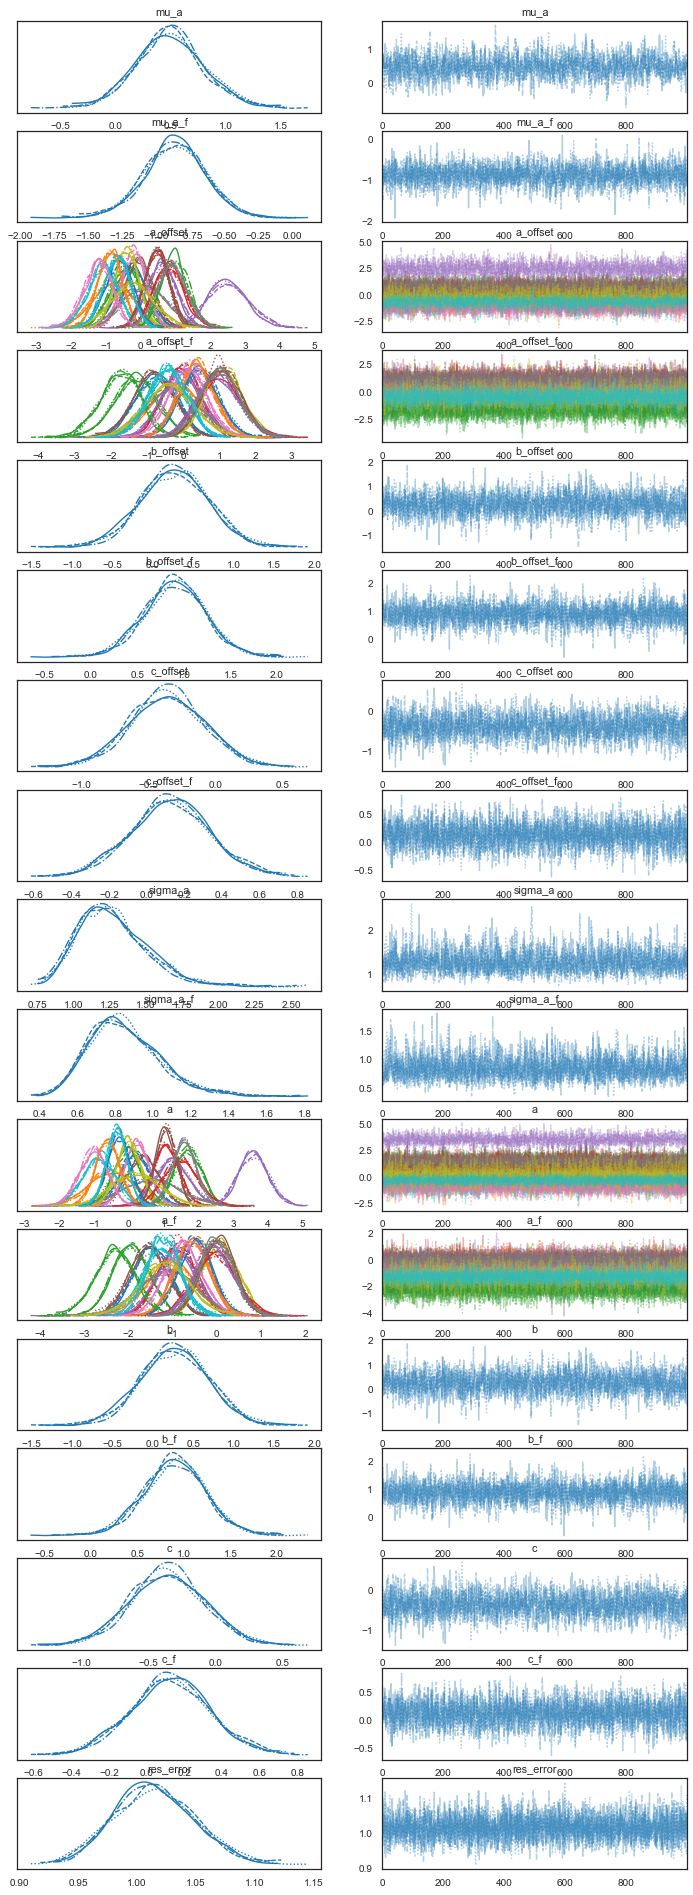

In [15]:
pm.plot_trace(hierarchical_trace)

/var/folders/9s/pz872p91741110p_4gz6llzc0000gn/T/ipykernel_7319/3188564304.py:3: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  forestplot(hierarchical_trace, var_names=['a'])
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/matthewscheffel/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

<Figure size 432x1008 with 0 Axes>

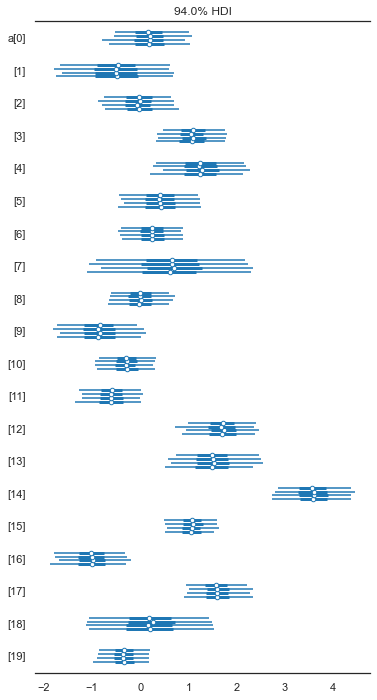

In [16]:
from pymc3 import forestplot, traceplot, plot_posterior
plt.figure(figsize=(6,14))
forestplot(hierarchical_trace, var_names=['a'])

# Part 2: Bayesian Model Averaging with Logistic Regression

1. First, revisit your HW2 and calculate the misclassification rate and the cross tabs for 3 variable models that used flat priors that performed best on the testing data. You will have 1 model for LDA and 1 model for QDA.

2. Next, use the provided BMA Wine class to fit a Bayesian Model Averaged logistic regression using the training data. Output the variable inclusion probabilities using the summary() function and interpret.

3. Finally, obtain the miss-classification rates and cross tabs for the BMA model applied to the training data and the testing data. Compare the performance of the BMA models to the performance of the best LDA and QDA models.

In [17]:
# load data sets

wine_training = pd.read_csv("whitewine-training-ds6040.csv")
wine_testing = pd.read_csv("whitewine-testing-ds6040.csv")

In [18]:
wine_training.head()

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,wine_quality
0,0.183032,-0.088263,0.223977,2.798612,-0.038083,0.549032,0.744783,2.293274,-1.231221,-0.336441,-1.395289,C
1,-0.640290,0.206999,0.056475,-0.946679,0.142355,-1.246502,-0.149673,-0.008274,0.711107,0.011581,-0.831034,C
2,1.476825,0.010158,0.558982,0.092590,0.187465,-0.319775,-0.973515,0.353398,0.452130,-0.423446,-0.347387,C
3,-0.757907,0.403840,-1.451043,0.112199,-0.038083,-0.319775,-0.055520,0.287640,-0.065824,-0.162430,-0.750426,C
4,0.183032,-0.088263,0.223977,2.798612,-0.038083,0.549032,0.744783,2.293274,-1.231221,-0.336441,-1.395289,C


In [19]:
wine_testing.head()

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,wine_quality
0,2.074706,2.095780,-0.370398,-0.442945,-0.924246,-0.963499,-0.878403,-0.770506,-1.210376,-0.994742,1.581632,F
1,0.752463,0.031237,0.597571,-1.000570,-0.077157,-1.447827,-0.290673,-0.380327,0.659670,-0.373157,-0.151371,F
2,-1.050596,-0.170181,0.032922,-1.000570,0.016964,-1.750531,-2.571065,-0.563331,0.728931,1.225203,-0.068847,F
3,-1.892024,1.541879,-1.822352,-1.040400,-0.783065,-1.750531,-2.053863,-1.129610,2.252672,-0.106764,0.591345,F
4,-0.569781,-0.371600,-0.370398,1.010863,0.252266,-0.176466,0.649694,0.955952,0.867453,-0.373157,-0.811562,F


In [20]:
from mpmath import mp
import numpy as np 
import pandas as pd 
import statsmodels.api as sm
from statsmodels.tools import add_constant
import itertools
from itertools import combinations
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style = "ticks")
mp.dps = 50

In [21]:
#This class is based on the BMA class provided by Bill Basener in: https://www.kaggle.com/billbasener/bayesian-model-averaging-logistic-regression
#It has been modified to allow for multinomial regression (logistic regression for more than 2 categories)
#Specifically, I've hardcoded the model as a 3 category multinomial regression, so this code doesn't generalize to any other model
class BMA_Wine:
    
    def __init__(self, y, X, **kwargs):
        # Setup the basic variables.
        self.y = y
        self.X = X
        self.names = list(X.columns)
        self.nRows, self.nCols = np.shape(X)
        self.likelihoods = mp.zeros(self.nCols,1)
        self.likelihoods_all = {}
        self.coefficients_mp = mp.zeros(self.nCols,2)
        self.coefficients = np.zeros((self.nCols, 2))
        self.probabilities = np.zeros(self.nCols)
        # Check the max model size. (Max number of predictor variables to use in a model.)
        # This can be used to reduce the runtime but not doing an exhaustive sampling.
        if 'MaxVars' in kwargs.keys():
            self.MaxVars = kwargs['MaxVars']
        else:
            self.MaxVars = self.nCols  
        # Prepare the priors if they are provided.
        # The priors are provided for the individual regressor variables.
        # The prior for a model is the product of the priors on the variables in the model.
        if 'Priors' in kwargs.keys():
            if np.size(kwargs['Priors']) == self.nCols:
                self.Priors = kwargs['Priors']
            else:
                print("WARNING: Provided priors error.  Using equal priors instead.")
                print("The priors should be a numpy array of length equal tot he number of regressor variables.")
                self.Priors = np.ones(self.nCols)  
        else:
            self.Priors = np.ones(self.nCols)  
        if 'Verbose' in kwargs.keys():
            self.Verbose = kwargs['Verbose'] 
        else:
            self.Verbose = False 
        if 'RegType' in kwargs.keys():
            self.RegType = kwargs['RegType'] 
        else:
            self.RegType = 'LS' 
        
    def fit(self):
        # Perform the Bayesian Model Averaging
        
        # Initialize the sum of the likelihoods for all the models to zero.  
        # This will be the 'normalization' denominator in Bayes Theorem.
        likelighood_sum = 0
        
        # To facilitate iterating through all possible models, we start by iterating thorugh
        # the number of elements in the model.  
        max_likelihood = 0
        for num_elements in range(1,self.MaxVars+1): 
            
            if self.Verbose == True:
                print("Computing BMA for models of size: ", num_elements)
            
            # Make a list of all index sets of models of this size.
            Models_current = list(combinations(list(range(self.nCols)), num_elements)) 
             
            # Occam's window - compute the candidate models to use for the next iteration
            # Models_previous: the set of models from the previous iteration that satisfy (likelihhod > max_likelihhod/20)
            # Models_next:     the set of candidate models for the next iteration
            # Models_current:  the set of models from Models_next that can be consturcted by adding one new variable
            #                    to a model from Models_previous
                                   
            
            # Iterate through all possible models of the given size.
            for model_index_set in Models_current:
                
                # Compute the linear regression for this given model. 
                model_X = self.X.iloc[:,list(model_index_set)]

                model_regr = sm.MNLogit(self.y, model_X).fit(disp=0)
                
                # Compute the likelihood (times the prior) for the model. 
                model_likelihood = mp.exp(-model_regr.bic/2)*np.prod(self.Priors[list(model_index_set)])
                
                if self.Verbose == True:
                    pass
                    #print("Model Variables:",model_index_set,"likelihood=",model_likelihood)
                self.likelihoods_all[str(model_index_set)] = model_likelihood
                
                # Add this likelihood to the running tally of likelihoods.
                likelighood_sum = mp.fadd(likelighood_sum, model_likelihood)
                # Add this likelihood (times the priors) to the running tally
                # of likelihoods for each variable in the model.
                for idx, i in zip(model_index_set, range(num_elements)):
                    self.likelihoods[idx] = mp.fadd(self.likelihoods[idx], model_likelihood, prec=2000)
                    for j in np.arange(model_regr.params.shape[1]):

                        self.coefficients_mp[idx,j] = mp.fadd(self.coefficients_mp[idx,j], model_regr.params[j][i]*model_likelihood, prec=2000)
                max_likelihood = np.max([max_likelihood,model_likelihood]) # get the new max likelihood if it is this model
                
                    

        # Divide by the denominator in Bayes theorem to normalize the probabilities 
        # sum to one.
        self.likelighood_sum = likelighood_sum
        for idx in range(self.nCols):
            self.probabilities[idx] = mp.fdiv(self.likelihoods[idx],likelighood_sum, prec=1000)
            for j in range(2):
                self.coefficients[idx,j] = mp.fdiv(self.coefficients_mp[idx,j],likelighood_sum, prec=1000)
        
        # Return the new BMA object as an output.
        return self
    
 
    def predict_MAP(self,true_class, data):
        data = np.asarray(data)
        result = np.zeros((data.shape[0],3))
        temp = sm.MNLogit(true_class, exog=np.asarray(data))
        result = temp.predict(params = self.coefficients, exog = np.asarray(data))
        result = pd.DataFrame(result, columns= ["A", "C", "F"])
        res_MAP = result.idxmax(axis=1)
        to_return = pd.DataFrame({'TrueClass':true_class, 'MAP':res_MAP})
        return to_return
    

    def misclass_rate(self, true_class, data):
        maps = self.predict_MAP(true_class, data)
        
        
        maps['Mis_class'] = maps['MAP']  == maps['TrueClass']
        
        mis_class =  1 - maps['Mis_class'].mean()
        
        return mis_class
    def misclass_xtabs(self, true_class, data):
        maps = self.predict_MAP(true_class, data)
        
        xtabs = pd.crosstab(maps['MAP'], maps['TrueClass'])        
        return xtabs
    
    def summary(self):
        # Return the BMA results as a data frame for easy viewing.
        df = pd.DataFrame([self.names, list(self.probabilities), list(self.coefficients)], 
             ["Variable Name", "Probability", "Avg. Coefficient"]).T
        return df  

In [22]:
# LDA Class (code given in example from Professor)
# used in HW 2 & 3

class LDA():
    def __init__(self, dataset, class_var, priors = None):
        n_class = len(dataset[class_var].unique())
        if priors is None:
            priors = np.repeat(1/n_class, n_class)
        self.priors =  np.asarray(priors)
        self.means = dataset.groupby(class_var).mean()
        self.sigma = dataset.cov()
        self.class_var = class_var
        self.training_data = dataset
    def predict_probs(self, data = None):
        if data is None:
            data = self.training_data
        data_temp = data.drop(self.class_var, axis = 1)
        dens_list = []
        col_names = []
        for ind, row in self.means.iterrows():
            col_names.append(ind)
            dens_list.append(multivariate_normal.pdf(data_temp, mean = np.asarray(row), cov = self.sigma))
        dens_list = pd.DataFrame(np.transpose(np.vstack(dens_list)),columns= col_names)
        dens_list = dens_list.mul(self.priors, axis=1)
        dens_list = dens_list.div(dens_list.sum(axis=1), axis=0)
        dens_list['True Class'] = data[self.class_var]
        return dens_list 
    def predict_MAP(self, data = None):        
        if data is None:
            data = self.training_data
        dens_list = self.predict_probs(data).drop('True Class', axis = 1)
        map_list = dens_list.idxmax(axis = 1)
        maps = {'MAP Class': map_list}
        maps = pd.DataFrame(maps)
        maps['True Class'] = data[self.class_var]
        return maps
    def misclass_rate(self, data = None):
        if data is None:
            data = self.training_data
        maps = self.predict_MAP(data = data)
        
        
        maps['Mis_class'] = maps['MAP Class']  == maps['True Class']
        
        mis_class =  1 - maps['Mis_class'].mean()
        
        return mis_class
    def misclass_xtabs(self, data = None):
        if data is None:
            data = self.training_data
        maps = self.predict_MAP(data = data)
        
        xtabs = pd.crosstab(maps['MAP Class'], maps['True Class'])        
        return xtabs
    def misclass_pairplot(self, data = None):
        if data is None:
            data = self.training_data
        maps = self.predict_MAP(data = data)
        temp_dat = data.copy(deep = True)
        temp_dat['Mis-Classified'] = maps['MAP Class']  != maps['True Class']
        plot = sns.pairplot(temp_dat,hue="Mis-Classified", height = 1.5, aspect = 1.5)   
        return plot

In [23]:
# QDA Class (code given in example from Professor)
# from HW 2

class QDA(LDA):
    def __init__(self, dataset, class_var, priors = None):
        n_class = len(dataset[class_var].unique())
        if priors is None:
            priors = np.repeat(1/n_class, n_class)
        self.priors = np.asarray(priors)
        self.means = dataset.groupby(class_var).mean()
        gb = dataset.groupby(class_var)
        self.sigma = {x: gb.get_group(x).cov() for x in gb.groups}
        self.class_var = class_var
        self.training_data = dataset
    def predict_probs(self, data = None):
        if data is None:
            data = self.training_data
        data_temp = data.drop(self.class_var, axis = 1)
        dens_list = []
        col_names = []
        for ind, row in self.means.iterrows():
            col_names.append(ind)
            dens_list.append(multivariate_normal.pdf(data_temp, mean = np.asarray(row), cov = np.asarray(self.sigma[ind])))
        dens_list = pd.DataFrame(np.transpose(np.vstack(dens_list)),columns= col_names)
        dens_list = dens_list.mul(self.priors, axis=1)
        dens_list = dens_list.div(dens_list.sum(axis=1), axis=0)
        dens_list['True Class'] = data[self.class_var]
        return dens_list 

# Calculate the misclassification rate and the cross tabs for 3 variable models that used flat priors that performed best on the testing data. You will have 1 model for LDA and 1 model for QDA:

# LDA:

In [24]:
# taken from HW 2

In [25]:
# loop over all combinations of 3 features, there will be 165 combinations
def three_features_combo(priors):
    features_combo = [list(x) for x in combinations(wine_training.drop('wine_quality', axis = 1), 3)]

    LDA_training_results = []
    LDA_testing_results = []

    # iterate combos 
    for combination in features_combo:
        current_columns = combination + ['wine_quality']
        train_three = wine_training[current_columns]
        test_three = wine_testing[current_columns]
        LDA_3 = LDA(train_three, 'wine_quality', priors = priors)
        train_misclass = LDA_3.misclass_rate()
        test_misclass = LDA_3.misclass_rate(test_three)
        LDA_training_results.append((current_columns, train_misclass))
        LDA_testing_results.append((current_columns, test_misclass))

    return(LDA_training_results, LDA_testing_results)

In [26]:
# use volatile.acidity, density, and alcohol as variables since they performed best in HW 2 flat priors section

# flat priors
flat_priors = [1/3, 1/3, 1/3]

LDA_Flat = LDA(wine_testing[["volatile.acidity", "density","alcohol", "wine_quality"]], 'wine_quality', priors = flat_priors)

In [27]:
LDA_Flat.misclass_rate()

0.47790697674418603

In [28]:
LDA_Flat.misclass_xtabs()

True Class,A,C,F
MAP Class,,,
A,49,307,46
C,22,413,158
F,9,280,436


# QDA: 

In [29]:
# taken from HW 2

In [30]:
# loop over all combinations of 3 features, there will be 165 combinations
def QDA_three_features_combo(priors):
    features_combo_2 = [list(x) for x in combinations(wine_training.drop('wine_quality', axis=1), 3)]

    QDA_training_results = []
    QDA_testing_results = []

    # iterate combos 
    for combination in features_combo_2:
        current_columns = combination + ['wine_quality']
        train_three_2 = wine_training[current_columns]
        test_three_2 = wine_testing[current_columns]
        QDA_3 = QDA(train_three_2, 'wine_quality', priors=priors)
        train_misclass = QDA_3.misclass_rate()
        test_misclass = QDA_3.misclass_rate(test_three_2)
        QDA_training_results.append((current_columns, train_misclass))
        QDA_testing_results.append((current_columns, test_misclass))

    return(QDA_training_results, QDA_testing_results)

In [31]:
# use volatile.acidity, density, and alcohol as variables since they performed best in HW 2 flat priors QDA section

# flat priors
flat_priors = [1/3, 1/3, 1/3]

QDA_Flat = QDA(wine_testing[["volatile.acidity", "free.sulfur.dioxide","alcohol", "wine_quality"]], 'wine_quality', priors = flat_priors)

In [32]:
QDA_Flat.misclass_rate()

0.45813953488372094

In [33]:
QDA_Flat.misclass_xtabs()

True Class,A,C,F
MAP Class,,,
A,49,305,30
C,25,399,126
F,6,296,484


# Use the provided BMA Wine class to fit a Bayesian Model Averaged logistic regression using the training data. Output the variable inclusion probabilities using the summary() function and interpret.

In [34]:
BMA_Log_Reg = BMA_Wine(wine_training['wine_quality'], add_constant(wine_training.iloc[:,:-1]), RegType='Logit', Verbose=True)

In [35]:
BMA_Log_Reg.fit()

Computing BMA for models of size:  1
Computing BMA for models of size:  2
Computing BMA for models of size:  3
Computing BMA for models of size:  4
Computing BMA for models of size:  5
Computing BMA for models of size:  6
Computing BMA for models of size:  7
Computing BMA for models of size:  8
Computing BMA for models of size:  9
Computing BMA for models of size:  10
Computing BMA for models of size:  11
Computing BMA for models of size:  12


In [36]:
BMA_Log_Reg.summary()

,Variable Name,Probability,Avg. Coefficient
0,const,1.0,"[3.554805025916327, 2.561719389128104]"
1,fixed.acidity,0.050937,"[0.006081316362694214, 0.012836499255148182]"
2,volatile.acidity,1.0,"[0.2520051321984379, 0.9405138587589458]"
3,citric.acid,0.00038,"[1.72439437612421e-05, 1.3338342052968865e-05]"
4,residual.sugar,1.0,"[-0.4297881784368679, -0.8224412258830641]"
5,chlorides,0.000432,"[5.9312647464358614e-05, 6.510663234553125e-05]"
6,free.sulfur.dioxide,0.237846,"[-0.06733716611616783, -0.09003553653549728]"
7,total.sulfur.dioxide,0.002822,"[0.0005234846449900891, 0.0008579730874491765]"
8,density,0.238925,"[0.17396196112899043, 0.29392454867368]"
9,pH,0.035454,"[-0.008840094487388952, -0.012972530705770762]"


The summary provides us with two important outputs: Probability and the Average Coefficient. Understanding the probabilities and coefficients aids in identifying important predictors that contribute significantly to the model's performance and can help guide us in further analysis.

The probability represents the likelihood that each predictor (variable) will be included in the final true model. A value of 1.0 indicates that the predictor is highly likely to be included, while smaller values suggest lower chances of inclusion. For instance, variables with a probability of 1.0, such as 'volatile.acidity', 'residual.sugar', and 'alcohol', are very likely to be part of the final true model.

The average coefficient for each predictor corresponds to its estimated effect on the target variable in the final true model. It provides insights into the direction and magnitude of the relationship between each predictor and the target variable. Negative coefficients suggest a negative impact on the target variable, while positive coefficients indicate a positive impact.

As mentioned before, 'volatile.acidity', 'residual.sugar', and 'alcohol' have probabilities of 1.0, implying that they are highly likely to be included in the final true model across BMA, LDA, and QDA. These predictors seem to have substantial explanatory power for the target variable. Volatile Acidity and Alcohol were utilized in all 3 of our models (BMA, LDA, and QDA). Conversely, predictors with lower probabilities might have weaker associations with the target variable or may not be consistently selected across the models.

# Obtain the miss-classification rates and cross tabs for the BMA model applied to the training data and the testing data. Compare the performance of the BMA models to the performance of the best LDA and QDA models.

# BMA Model:

### Training:

In [37]:
BMA_Log_Reg.misclass_rate(wine_training['wine_quality'], add_constant(wine_training.iloc[:,:-1]))

0.2709251101321586

In [38]:
BMA_Log_Reg.misclass_xtabs(wine_training['wine_quality'], add_constant(wine_training.iloc[:,:-1]))

TrueClass,A,C,F
MAP,,,
C,98,1845,528
F,2,233,472


### Testing: 

In [39]:
BMA_Log_Reg.misclass_rate(wine_testing['wine_quality'], add_constant(wine_testing.iloc[:,:-1]))

0.30988372093023253

In [40]:
BMA_Log_Reg.misclass_xtabs(wine_testing['wine_quality'], add_constant(wine_testing.iloc[:,:-1]))

TrueClass,A,C,F
MAP,,,
C,79,904,357
F,1,96,283


# Best LDA:

In [47]:
# use volatile.acidity, density, alcohol

Best_LDA = LDA(wine_training[["volatile.acidity", "density","alcohol", "wine_quality"]], 'wine_quality')

In [48]:
Best_LDA.misclass_rate(wine_testing[["volatile.acidity", "density", "alcohol", "wine_quality"]])

0.4877906976744186

In [49]:
Best_LDA.misclass_xtabs(wine_testing[["volatile.acidity", "density", "alcohol", "wine_quality"]])

True Class,A,C,F
MAP Class,,,
A,55,335,48
C,17,390,156
F,8,275,436


# Best QDA:

In [50]:
# use volatile.acidity, free.sulfur.dioxide, alcohol

Best_QDA = QDA(wine_training[["volatile.acidity", "free.sulfur.dioxide","alcohol", "wine_quality"]], 'wine_quality')

In [51]:
Best_QDA.misclass_rate(wine_testing[["volatile.acidity", "free.sulfur.dioxide", "alcohol", "wine_quality"]])

0.4511627906976744

In [52]:
Best_QDA.misclass_xtabs(wine_testing[["volatile.acidity", "free.sulfur.dioxide", "alcohol", "wine_quality"]])

True Class,A,C,F
MAP Class,,,
A,48,299,35
C,26,437,146
F,6,264,459


# Model Comparison:

Among the three models, the BMA model achieved the lowest misclassification rates on both the training and testing datasets, making it the best-performing model in terms of overall classification accuracy. The LDA and QDA models performed relatively worse, with higher misclassification rates compared to the BMA model.

### Bayesian Model Averaging (BMA) Model:

The BMA model achieved the lowest misclassification rates on both the training and testing datasets, indicating its strong classification performance compared to the other models. This suggests that the BMA model's ability to average over different models and predictors contributes to its superior performance in handling complex datasets with multiple potential predictors. The cross-tabulations show that the BMA model achieved relatively balanced predictions across all classes, especially for the 'C' and 'F' classes. This balance in predictions might indicate that the BMA model is generalizing well and is less prone to overfitting, which can be particularly important when dealing with imbalanced datasets or complex class distributions.

### Linear Discriminant Analysis (LDA) Model:

The LDA model achieved higher misclassification rates compared to the both the BMA and QDA models, suggesting that it might not be capturing the underlying complexities of the dataset as effectively. LDA's linear nature might limit its ability to handle non-linear relationships between predictors and the target variable. The cross-tabulations show that the LDA model exhibits challenges in classifying the 'A' class correctly, with a higher number of misclassifications. This indicates that the LDA model may struggle with distinguishing the 'A' class from the other classes, possibly due to overlapping feature distributions.

### Quadratic Discriminant Analysis (QDA) Model:

The QDA model achieved misclassification rates that are lower than LDA but higher than the BMA model. This suggests that QDA's flexibility in allowing different covariance matrices for each class offers some improvement over LDA but might still be less effective than the BMA model in this specific context.
The cross-tabulations reveal challenges in correctly classifying the 'A' class, similar to the LDA model. However, the QDA model seems to perform better than LDA in distinguishing the 'A' and 'C' classes, as indicated by the higher number of correct classifications for class 'A' in comparison.

In summary, the comparison and insights reveal that the Bayesian Model Averaging (BMA) model stands out as the best performer among the three models for the classification task at hand. Its ability to handle multiple potential predictors and model uncertainty, along with its balanced predictions, contribute to its superior classification performance. While LDA and QDA have their strengths, the BMA model emerges as our most promising choice when dealing with complex datasets and multiple predictors. Overall, based on the misclassification rates, the BMA model appears to be the most reliable and robust model for this specific classification problem. However, it's also important to consider other factors, such as interpretability and specific objectives, when choosing the best model.

# Extra Credit

### LDA and QDA

Both Linear Discriminant Analysis (LDA) and Quadratic Discriminant Analysis (QDA) are classification techniques for multinomial logistic regression. 

LDA assumes Gaussian-distributed features with equal covariance matrices across classes, resulting in a linear decision boundary. This assumption simplifies the model and makes it computationally efficient, especially in high-dimensional datasets with limited training data. As such, LDA aims to find a linear combination of features that optimally separates the classes by maximizing the distance between class means and minimizing within-class variance. 

Alternatively, QDA relaxes the assumption of equal covariance matrices and allows each class to have its own covariance matrix. This flexibility allows QDA to capture more complex relationships between features and classes with quadratic decision boundaries. However, the cost of this flexibility is increased computational complexity, especially when dealing with high-dimensional data or a large number of classes. QDA seeks to find a quadratic decision boundary that optimally separates the classes, and in doing so, it can capture more intricate and nonlinear data patterns compared to LDA. 

The choice between these methods depends on the underlying data distribution and the complexity of relationships between features and classes, with LDA being more computationally efficient but assuming a simpler decision boundary and QDA allowing greater flexibility.

### BIC and Bayes Factor:

The Bayesian Information Criterion (BIC) serves as an approximation to the Bayes Factor, which directly quantifies the strength of evidence for one model over another. The Bayes Factor calculates the likelihood of the data under two competing models and expresses the ratio of those likelihoods. A Bayes Factor greater than 1 indicates evidence in favor of one model, while a Bayes Factor less than 1 suggests evidence for the other model. Essentially, the Bayes Factor weighs the relative support for each model based on how well they explain the observed data.

BIC takes a different approach to model comparison that involves computing the log-likelihood of the data given each model, measuring the goodness of fit for the models. However, the BIC also includes a penalty term based on the number of parameters in each model. This penalty term discourages overly complex models by penalizing those with more parameters and favoring simpler explanations when models are equally effective in fitting the data. The balance between the log-likelihood term (goodness of fit) and the penalty term (model complexity) in the BIC determines the final score assigned to each model. The BIC allows for the comparison of different models and selects the one with the lowest BIC value. A lower BIC value indicates a model that strikes an optimal balance between fit and complexity, making it a suitable candidate for the observed data.

The BIC is computationally efficient and works well for for large datasets due to its approximation nature and the simplicity of it. It is often used in machine learning and statistics to help guide model selection. At times, the Bayes Factor provides a more accurate and direct measure of the evidence supporting one model over another, such as when comparing complex models with many parameters. However, Bayes Factors also tend to have higher computational costs than the BIC, making it less practical for usage in a large-scale analysis. 